# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries

In [197]:
import warnings
warnings.filterwarnings("ignore")

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [199]:
# 데이터셋 읽기
df = pd.read_csv('./data/CICIDS2017.csv')

# 'Label' 열의 이름에서 공백 제거
df.columns = df.columns.str.strip()

# 모든 열에 대해 공백 제거 적용
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 'Label' 열을 기준으로 값 계산
df['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [200]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.000000,0.000000,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.000000,0.000000,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,55641,49,1,3,6,18,6,6,6.000000,0.000000,...,20,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2830739,45337,217,2,1,31,6,31,0,15.500000,21.920310,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2830740,22,1387547,41,46,2728,6634,456,0,66.536585,110.129945,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2830741,22,207,1,1,0,0,0,0,0.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN


In [201]:
df.Label.value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [202]:
df['Label'] = df['Label'].replace(to_replace=r'^Web Attack.*', value='WebAttack', regex=True)
df['Label'] = df['Label'].replace(to_replace=r'^D.*', value='Dos', regex=True)
df['Label'] = df['Label'].replace(to_replace=r'^FTP-.*', value='BruteForce', regex=True)
df['Label'] = df['Label'].replace(to_replace=r'^SSH-.*', value='BruteForce', regex=True)
df['Label'] = df['Label'].replace(to_replace=r'^Heartbleed', value='Dos', regex=True)

In [203]:
df.Label.value_counts()

Label
BENIGN          2273097
Dos              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: count, dtype: int64

In [204]:
output_path = './data/CICIDS2017_mapped.csv'

df.to_csv(output_path, index=False)

### Preprocessing (normalization and padding values)

In [205]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [206]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.440256,-0.439342,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
1,2.848259,-0.439344,-0.011153,-0.008416,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
2,-0.434732,-0.436377,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,0.002564,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
3,-0.434732,-0.438247,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
4,-0.441459,2.863743,0.183599,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002527,2.578171,5.292733,4.552248,-0.100852,0.048540,0.467932,0.201267,-0.095009,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,2.601754,-0.439345,-0.011153,-0.007413,-0.054365,-0.007134,-0.281099,-0.210703,-0.280518,-0.245069,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
2830739,2.038190,-0.439340,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
2830740,-0.440256,-0.398117,0.042204,0.035699,0.218010,-0.004210,0.346354,-0.310140,0.044788,0.146592,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
2830741,-0.440256,-0.439341,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN


In [207]:
# Label 열에 있는 고유한 값들을 확인
df.Label.value_counts()

Label
BENIGN          2273097
Dos              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: count, dtype: int64

In [208]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [209]:
df.Label.value_counts()

Label
0    2273097
3     380699
5     158930
2      13835
6       2180
1       1966
4         36
Name: count, dtype: int64

In [210]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [211]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [212]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [213]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [214]:
df_major['klabel'].value_counts()

klabel
165    26366
227    14871
6      14754
31     14470
33     14387
       ...  
853       42
104       24
475       21
131        7
694        2
Name: count, Length: 997, dtype: int64

In [215]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [216]:
df_major

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,klabel
0,-0.440256,-0.439342,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,710
1,2.848259,-0.439344,-0.011153,-0.008416,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,547
2,-0.434732,-0.436377,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,227
3,-0.434732,-0.438247,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,227
4,-0.441459,2.863743,0.183599,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,2.578171,5.292733,4.552248,-0.100852,0.048540,0.467932,0.201267,-0.095009,0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,2.601754,-0.439345,-0.011153,-0.007413,-0.054365,-0.007134,-0.281099,-0.210703,-0.280518,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,592
2830739,2.038190,-0.439340,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,225
2830740,-0.440256,-0.398117,0.042204,0.035699,0.218010,-0.004210,0.346354,-0.310140,0.044788,0.146592,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,571
2830741,-0.440256,-0.439341,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,0,710


In [217]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [218]:
result['Label'].value_counts()

Label
0    18225
3     3011
5     1279
2      112
Name: count, dtype: int64

In [219]:
result

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,klabel
995217,-0.438561,-0.438648,-0.011153,-0.009418,-0.050262,-0.007065,-0.223931,0.468788,-0.060196,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
949756,-0.438561,-0.438408,-0.011153,-0.009418,-0.050062,-0.007064,-0.221142,0.501934,-0.049449,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
2470630,-0.438561,-0.436479,-0.011153,-0.009418,-0.050262,-0.007066,-0.223931,0.468788,-0.060196,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
512478,-0.438561,-0.438430,-0.011153,-0.009418,-0.050062,-0.007064,-0.221142,0.501934,-0.049449,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
784725,-0.438561,-0.437335,-0.009819,-0.008416,-0.045760,-0.006988,-0.225325,0.452215,-0.065570,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518644,2.728862,-0.439338,-0.008485,-0.010421,-0.051863,-0.007142,-0.246240,-0.310140,-0.257232,-0.181418,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
1891634,2.696210,-0.439345,-0.008485,-0.009418,-0.051863,-0.007142,-0.246240,-0.310140,-0.257232,-0.181418,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
1795518,2.986689,-0.439335,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999
1269143,2.872433,-0.439336,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0,999


In [220]:
result = result.drop(['klabel'],axis=1)
# result = pd.concat([result, df_minor], ignore_index=True)

In [221]:
result = pd.concat([result, df_minor], ignore_index=True)

In [222]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [223]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [224]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [226]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [227]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [228]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [229]:
X_fs = df[fs].values

In [230]:
X_fs.shape

(26809, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [231]:
# -*- coding: utf-8 -*-
import numpy as np


def count_vals(x):
    vals = np.unique(x)
    occ = np.zeros(shape=vals.shape)
    for i in range(vals.size):
        occ[i] = np.sum(x == vals[i])
    return occ


def entropy(x):
    n = float(x.shape[0])
    ocurrence = count_vals(x)
    px = ocurrence / n
    return -1 * np.sum(px * np.log2(px))


def symmetricalUncertain(x, y):
    n = float(y.shape[0])
    vals = np.unique(y)
    # Computing Entropy for the feature x. 
    Hx = entropy(x)
    # Computing Entropy for the feature y.
    Hy = entropy(y)
    #Computing Joint entropy between x and y.
    partial = np.zeros(shape=(vals.shape[0]))
    for i in range(vals.shape[0]):
        partial[i] = entropy(x[y == vals[i]])

    partial[np.isnan(partial) == 1] = 0
    py = count_vals(y).astype(dtype='float64') / n
    Hxy = np.sum(py[py > 0] * partial)
    IG = Hx - Hxy
    return 2 * IG / (Hx + Hy)


def suGroup(x, n):
    m = x.shape[0]
    x = np.reshape(x, (n, m / n)).T
    m = x.shape[1]
    SU_matrix = np.zeros(shape=(m, m))
    for j in range(m - 1):
        x2 = x[:, j + 1::]
        y = x[:, j]
        temp = np.apply_along_axis(symmetricalUncertain, 0, x2, y)
        for k in range(temp.shape[0]):
            SU_matrix[j, j + 1::] = temp
            SU_matrix[j + 1::, j] = temp

    return 1 / float(m - 1) * np.sum(SU_matrix, axis=1)


def isprime(a):
    return all(a % i for i in xrange(2, a))


"""
get
"""


def get_i(a):
    if isprime(a):
        a -= 1
    return filter(lambda x: a % x == 0, range(2, a))


"""
FCBF - Fast Correlation Based Filter

L. Yu and H. Liu. Feature Selection for High‐Dimensional Data: A Fast Correlation‐Based Filter Solution. 
In Proceedings of The Twentieth International Conference on Machine Leaning (ICML‐03), 856‐863.
Washington, D.C., August 21‐24, 2003.
"""


class FCBF:
    idx_sel = []

    def __init__(self, th=0.01):
        '''
        Parameters
        ---------------
            th = The initial threshold 
        '''
        self.th = th

    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        SU_list = SU_vec[SU_vec > self.th]
        SU_list[::-1].sort()

        m = x[:, SU_vec > self.th].shape
        x_sorted = np.zeros(shape=m)

        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:, i] = x[:, ind].copy()
            self.idx_sel.append(ind)

        """
        Second Stage: Identify relationships between feature to remove redundancy.
        """
        j = 0
        while True:
            """
            Stopping Criteria:The search finishes
            """
            if j >= x_sorted.shape[1]: break
            y = x_sorted[:, j].copy()
            x_list = x_sorted[:, j + 1:].copy()
            if x_list.shape[1] == 0: break

            SU_list_2 = SU_list[j + 1:]
            SU_x = np.apply_along_axis(symmetricalUncertain, 0,
                                       x_list, y)

            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1
            if to_remove.size > 0:
                x_sorted = np.delete(x_sorted, to_remove, axis=1)
                SU_list = np.delete(SU_list, to_remove, axis=0)
                to_remove.sort()
                for r in reversed(to_remove):
                    self.idx_sel.remove(self.idx_sel[r])
            j = j + 1

    def fit_transform(self, x, y):
        '''
        This function fits the feature selection 
        algorithm and returns the resulting subset.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.fit(x, y)
        return x[:, self.idx_sel]

    def transform(self, x):
        '''
        This function applies the selection
        to the vector x.
        
        Parameters
        ---------------
            x = dataset  [NxM] 
        '''
        return x[:, self.idx_sel]


"""
FCBF# - Fast Correlation Based Filter 
B. Senliol, G. Gulgezen, et al. Fast Correlation Based Filter (FCBF) with a Different Search Strategy. 
In Computer and Information Sciences (ISCIS ‘08) 23rd International Symposium on, pages 1‐4. 
Istanbul, October 27‐29, 2008.
"""


class FCBFK(FCBF):
    idx_sel = []

    def __init__(self, k=10):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
        '''
        self.k = k

    def fit(self, x, y):
        '''
        This function executes FCBFK algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''
        self.idx_sel = []
        """
        First Stage: Computing the SU for each feature with the response.
        """
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)

        SU_list = SU_vec[SU_vec > 0]
        SU_list[::-1].sort()

        m = x[:, SU_vec > 0].shape
        x_sorted = np.zeros(shape=m)

        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:, i] = x[:, ind].copy()
            self.idx_sel.append(ind)

        """
        Second Stage: Identify relationships between features to remove redundancy with stopping 
        criteria (features in x_best == k).
        """
        j = 0
        while True:
            y = x_sorted[:, j].copy()
            SU_list_2 = SU_list[j + 1:]
            x_list = x_sorted[:, j + 1:].copy()

            """
            Stopping Criteria:The search finishes
            """
            if x_list.shape[1] == 0: break

            SU_x = np.apply_along_axis(symmetricalUncertain, 0,
                                       x_list, y)

            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1
            if to_remove.size > 0 and x.shape[1] > self.k:

                for i in reversed(to_remove):

                    x_sorted = np.delete(x_sorted, i, axis=1)
                    SU_list = np.delete(SU_list, i, axis=0)
                    self.idx_sel.remove(self.idx_sel[i])
                    if x_sorted.shape[1] == self.k: break

            if x_list.shape[1] == 1 or x_sorted.shape[1] == self.k:
                break
            j = j + 1

        if len(self.idx_sel) > self.k:
            self.idx_sel = self.idx_sel[:self.k]


"""
FCBFiP - Fast Correlation Based Filter in Pieces
"""


class FCBFiP(FCBF):
    idx_sel = []

    def __init__(self, k=10, npieces=2):
        '''
        Parameters
        ---------------
            k = Number of features to include in the
            subset.
            npieces = Number of pieces to divide the 
            feature space.
        '''
        self.k = k
        self.npieces = npieces

    def fit(self, x, y):
        '''
        This function executes FCBF algorithm and saves indexes 
        of selected features in self.idx_sel
        
        Parameters
        ---------------
            x = dataset  [NxM] 
            y = label    [Nx1]
        '''

        """
        First Stage: Computing the SU for each feature with the response. We sort the 
        features. When we have a prime number of features we remove the last one from the
        sorted features list.
        """
        m = x.shape
        nfeaturesPieces = int(m[1] / float(self.npieces))
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)

        x_sorted = np.zeros(shape=m, dtype='float64')
        idx_sorted = np.zeros(shape=m[1], dtype='int64')
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = -1
            idx_sorted[i] = ind
            x_sorted[:, i] = x[:, ind].copy()

        if isprime(m[1]):
            x_sorted = np.delete(x_sorted, m[1] - 1, axis=1)
            ind_prime = idx_sorted[m[1] - 1]
            idx_sorted = np.delete(idx_sorted, m[1] - 1)
            #m = x_sorted.shape
        """
        Second Stage: Identify relationships between features into its vecinity
        to remove redundancy with stopping criteria (features in x_best == k).
        """

        x_2d = np.reshape(x_sorted.T, (self.npieces, nfeaturesPieces * m[0])).T

        SU_x = np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
        SU_x = np.reshape(SU_x.T, (self.npieces * nfeaturesPieces,))
        idx_sorted2 = np.zeros(shape=idx_sorted.shape, dtype='int64')
        SU_x[np.isnan(SU_x)] = 1

        for i in range(idx_sorted.shape[0]):
            ind = np.argmin(SU_x)
            idx_sorted2[i] = idx_sorted[ind]
            SU_x[ind] = 10

        """
        Scoring step
        """
        self.scores = np.zeros(shape=m[1], dtype='int64')

        for i in range(m[1]):
            if i in idx_sorted:
                self.scores[i] = np.argwhere(i == idx_sorted) + np.argwhere(i == idx_sorted2)
        if isprime(m[1]):
            self.scores[ind_prime] = 2 * m[1]
        self.set_k(self.k)

    def set_k(self, k):
        self.k = k
        scores_temp = -1 * self.scores

        self.idx_sel = np.zeros(shape=self.k, dtype='int64')
        for i in range(self.k):
            ind = np.argmax(scores_temp)
            scores_temp[ind] = -100000000
            self.idx_sel[i] = ind


In [232]:
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [233]:
X_fss = fcbf.fit_transform(X_fs,y)

In [234]:
X_fss.shape

(26809, 20)

### Re-split train & test sets after feature selection

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [236]:
X_train.shape

(21447, 20)

In [237]:
pd.Series(y_train).value_counts()

0    14580
3     2409
6     1744
1     1573
5     1023
2       89
4       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [238]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [239]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [240]:
pd.Series(y_train).value_counts()

0    14580
3     2409
6     1744
1     1573
5     1023
4     1000
2     1000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9934725848563969
Precision of XGBoost: 0.9936450833324382
Recall of XGBoost: 0.9934725848563969
F1-score of XGBoost: 0.9935117308538883
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       0.96      1.00      0.98        23
           3       0.99      1.00      0.99       602
           4       0.78      1.00      0.88         7
           5       1.00      0.99      1.00       256
           6       0.97      1.00      0.98       436

    accuracy                           0.99      5362
   macro avg       0.95      1.00      0.97      5362
weighted avg       0.99      0.99      0.99      5362



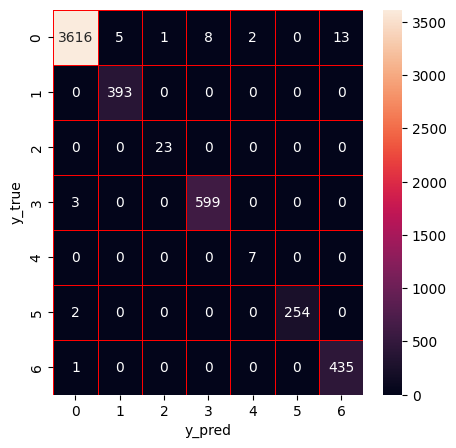

In [241]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [242]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Objective function for Hyperopt
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
    }
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Hyperparameter search space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

# Running the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# 출력된 best에는 최적의 하이퍼파라미터가 담겨 있습니다.
print("XGBoost: Hyperopt estimated optimum {}".format(best))


100%|██████████| 20/20 [00:17<00:00,  1.17trial/s, best loss: -0.9972025363670273]
XGBoost: Hyperopt estimated optimum {'learning_rate': np.float64(0.24868606684503988), 'max_depth': np.float64(66.0), 'n_estimators': np.float64(85.0)}


Accuracy of XGBoost: 0.9972025363670273
Precision of XGBoost: 0.9972184190556084
Recall of XGBoost: 0.9972025363670273
F1-score of XGBoost: 0.9972057516552961
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00       256
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5362
   macro avg       1.00      1.00      1.00      5362
weighted avg       1.00      1.00      1.00      5362



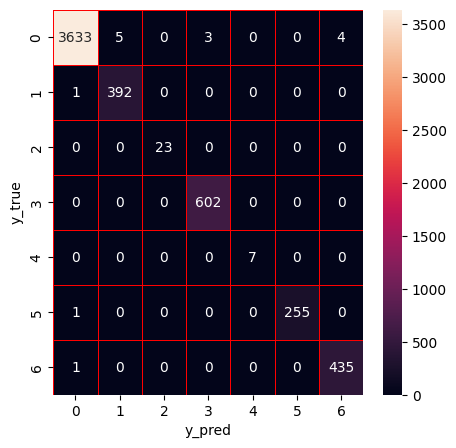

In [243]:
xg = xgb.XGBClassifier(
    learning_rate=abs(float(best['learning_rate'])),
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth'])
)

# 모델 학습
xg.fit(X_train, y_train)

# 모델 예측 및 성능 평가
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test

# 평가 결과 출력
print('Accuracy of XGBoost: ' + str(xg_score))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [244]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9968295412159642
Precision of RF: 0.9968339445103337
Recall of RF: 0.9968295412159642
F1-score of RF: 0.996830389175207
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       0.99      0.99      0.99       256
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5362
   macro avg       1.00      1.00      1.00      5362
weighted avg       1.00      1.00      1.00      5362



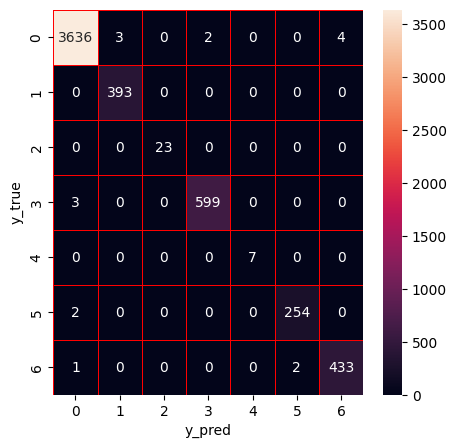

In [245]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [246]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': str(params['criterion'])
    }
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Running the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# 최적화 결과 출력
print("Random Forest: Hyperopt estimated optimum {}".format(best))


100%|██████████| 20/20 [01:07<00:00,  3.38s/trial, best loss: -0.9966430436404327]
Random Forest: Hyperopt estimated optimum {'criterion': np.int64(1), 'max_depth': np.float64(20.0), 'max_features': np.float64(10.0), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(11.0), 'n_estimators': np.float64(85.0)}


Accuracy of RF: 0.9966430436404327
Precision of RF: 0.9966997695984118
Recall of RF: 0.9966430436404327
F1-score of RF: 0.9966535808939547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       1.00      0.99      1.00       256
           6       0.98      1.00      0.99       436

    accuracy                           1.00      5362
   macro avg       0.99      1.00      1.00      5362
weighted avg       1.00      1.00      1.00      5362



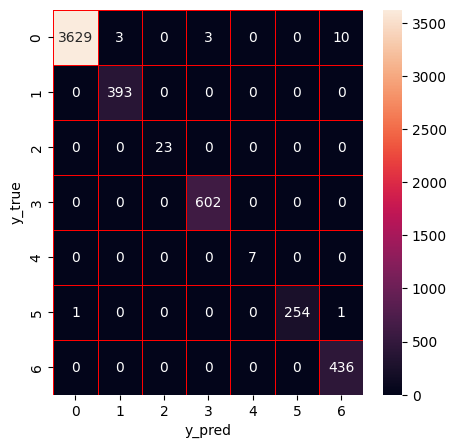

In [247]:
# 최적화된 하이퍼파라미터를 사용하여 RandomForestClassifier를 정의
rf_hpo = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    max_features=int(best['max_features']),
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion=['gini', 'entropy'][best['criterion']]
)

# 모델 학습
rf_hpo.fit(X_train, y_train)

# 모델 예측 및 성능 평가
rf_score = rf_hpo.score(X_test, y_test)
y_predict = rf_hpo.predict(X_test)
y_true = y_test

# 평가 결과 출력
print('Accuracy of RF: ' + str(rf_score))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [248]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.994964565460649
Precision of DT: 0.9949939387686709
Recall of DT: 0.994964565460649
F1-score of DT: 0.9949705908488156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       0.88      1.00      0.93         7
           5       0.99      0.98      0.99       256
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5362
   macro avg       0.98      0.99      0.98      5362
weighted avg       0.99      0.99      0.99      5362



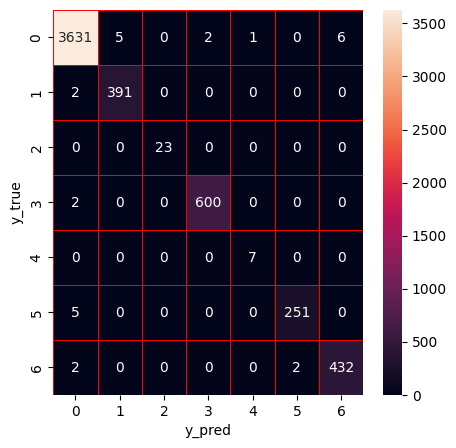

In [249]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [250]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': str(params['criterion'])
    }
    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Running the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# 최적화 결과 출력
print("Decision tree: Hyperopt estimated optimum {}".format(best))


100%|██████████| 50/50 [00:02<00:00, 19.87trial/s, best loss: -0.9953375606117121]
Decision tree: Hyperopt estimated optimum {'criterion': np.int64(1), 'max_depth': np.float64(37.0), 'max_features': np.float64(20.0), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(8.0)}


Accuracy of DT: 0.994964565460649
Precision of DT: 0.9949788948910002
Recall of DT: 0.994964565460649
F1-score of DT: 0.9949619689598324
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        23
           3       0.99      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       1.00      0.98      0.99       256
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5362
   macro avg       0.99      0.99      0.99      5362
weighted avg       0.99      0.99      0.99      5362



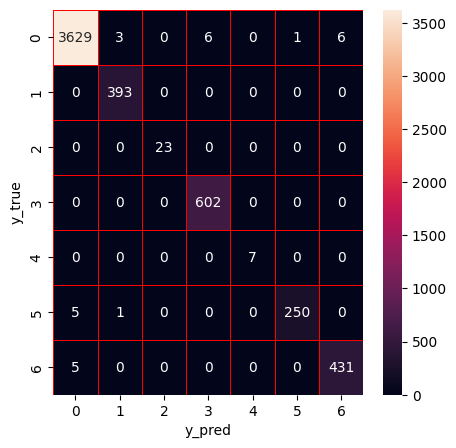

In [251]:
# 최적화된 하이퍼파라미터를 사용하여 DecisionTreeClassifier를 정의
dt_hpo = DecisionTreeClassifier(
    max_depth=int(best['max_depth']),
    max_features=int(best['max_features']),
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion=['gini', 'entropy'][best['criterion']]
)

# 모델 학습
dt_hpo.fit(X_train, y_train)

# 모델 예측 및 성능 평가
dt_score = dt_hpo.score(X_test, y_test)
y_predict = dt_hpo.predict(X_test)
y_true = y_test

# 평가 결과 출력
print('Accuracy of DT: ' + str(dt_score))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [252]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9960835509138382
Precision of ET: 0.9960886568164595
Recall of ET: 0.9960835509138382
F1-score of ET: 0.9960847482830056
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        23
           3       0.99      1.00      0.99       602
           4       0.86      0.86      0.86         7
           5       1.00      0.99      0.99       256
           6       0.99      1.00      0.99       436

    accuracy                           1.00      5362
   macro avg       0.98      0.98      0.98      5362
weighted avg       1.00      1.00      1.00      5362



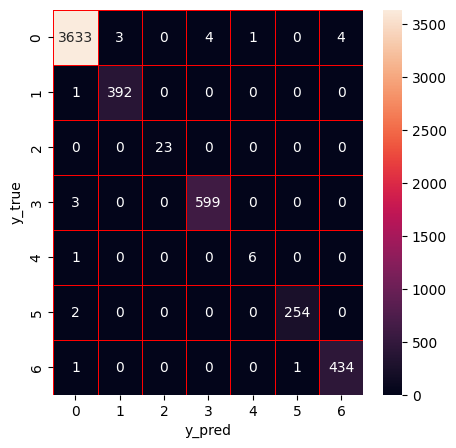

In [253]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [254]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': str(params['criterion'])
    }
    clf = ExtraTreesClassifier(**params)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Running the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# 최적화 결과 출력
print("Extra Trees: Hyperopt estimated optimum {}".format(best))


100%|██████████| 20/20 [00:11<00:00,  1.69trial/s, best loss: -0.9927265945542708]
Extra Trees: Hyperopt estimated optimum {'criterion': np.int64(1), 'max_depth': np.float64(28.0), 'max_features': np.float64(19.0), 'min_samples_leaf': np.float64(8.0), 'min_samples_split': np.float64(5.0), 'n_estimators': np.float64(67.0)}


Accuracy of ET: 0.9910481163744871
Precision of ET: 0.9912780256865574
Recall of ET: 0.9910481163744871
F1-score of ET: 0.9910822583041872
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.96      1.00      0.98       393
           2       1.00      1.00      1.00        23
           3       0.98      1.00      0.99       602
           4       1.00      0.86      0.92         7
           5       1.00      0.99      0.99       256
           6       0.97      1.00      0.98       436

    accuracy                           0.99      5362
   macro avg       0.99      0.98      0.98      5362
weighted avg       0.99      0.99      0.99      5362



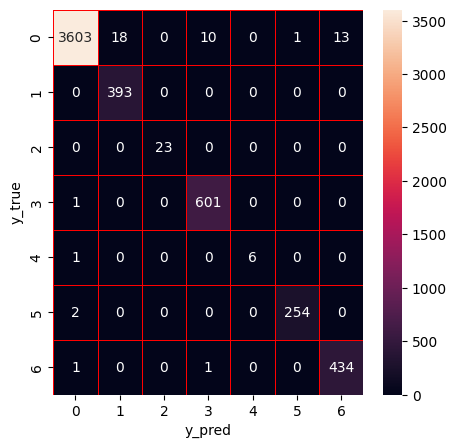

In [255]:
# 최적화된 하이퍼파라미터를 사용하여 ExtraTreesClassifier를 정의
et_hpo = ExtraTreesClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    max_features=int(best['max_features']),
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    criterion=['gini', 'entropy'][best['criterion']]
)

# 모델 학습
et_hpo.fit(X_train, y_train)

# 모델 예측 및 성능 평가
et_score = et_hpo.score(X_test, y_test)
y_predict = et_hpo.predict(X_test)
y_true = y_test

# 평가 결과 출력
print('Accuracy of ET: ' + str(et_score))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [256]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [257]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,3,3,3,3
4,6,6,6,6


In [258]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [259]:
dt_train.shape

(23329, 1)

In [260]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9966430436404327
Precision of Stacking: 0.996651200818168
Recall of Stacking: 0.9966430436404327
F1-score of Stacking: 0.9966437529404503
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00       256
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5362
   macro avg       1.00      1.00      1.00      5362
weighted avg       1.00      1.00      1.00      5362



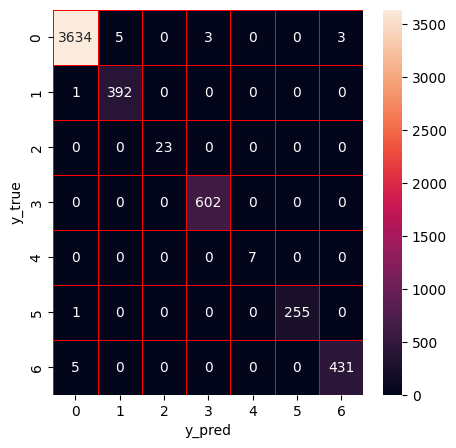

In [261]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [262]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:05<00:00,  3.96trial/s, best loss: -0.9972025363670273]
XGBoost: Hyperopt estimated optimum {'learning_rate': np.float64(0.018538516421554494), 'max_depth': np.float64(27.0), 'n_estimators': np.float64(75.0)}


Accuracy of XGBoost: 0.9966430436404327
Precision of XGBoost: 0.996651200818168
Recall of XGBoost: 0.9966430436404327
F1-score of XGBoost: 0.9966437529404503
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00       602
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00       256
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5362
   macro avg       1.00      1.00      1.00      5362
weighted avg       1.00      1.00      1.00      5362



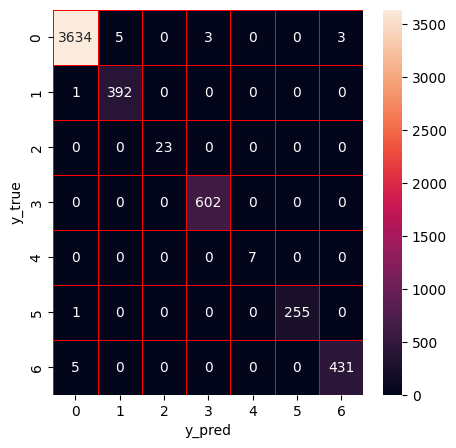

In [263]:
xg = xgb.XGBClassifier(learning_rate= 0.40689651658325954, n_estimators = 80, max_depth = 78)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [264]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [265]:
df.Label.value_counts()

Label
0    18225
3     3011
6     2180
1     1966
5     1279
2      112
4       36
Name: count, dtype: int64

In [266]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [267]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [268]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [269]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [270]:
df1.Label.value_counts()

Label
0    18225
1     7305
Name: count, dtype: int64

In [271]:
df2.Label.value_counts()

Label
1    1279
Name: count, dtype: int64

In [272]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [273]:
df2.Label.value_counts()

Label
1    1279
0    1255
Name: count, dtype: int64

In [274]:
df = pd.concat([df1, df2])

In [275]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19480
1     8584
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [276]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [277]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [278]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [279]:
X_fs = df[fs].values

In [280]:
X_fs.shape

(28064, 50)

In [281]:
X_fs

array([[-0.44367006, -0.36799705, -0.3241843 , ..., -0.12499432,
        -0.14943533, -0.10354125],
       [-0.44367006, -0.36799705, -0.3241843 , ..., -0.12499432,
        -0.14943533, -0.10354125],
       [-0.44367006, -0.36799705, -0.32702734, ..., -0.12499432,
        -0.14943533, -0.10354125],
       ...,
       [-0.44367006, -0.36799705, -0.38388814, ..., -0.12499432,
        -0.14943533, -0.10354125],
       [ 2.50840949, -0.36799705, -0.41042318, ..., -0.12499432,
        -0.14943533, -0.10354125],
       [-0.44367006, -0.36799705, -0.39603969, ..., -0.12499432,
        -0.14943533, -0.10354125]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [282]:
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [283]:
X_fss = fcbf.fit_transform(X_fs,y)

In [284]:
X_fss.shape

(28064, 20)

In [285]:
X_fss

array([[-0.44367006, -0.36799705, -0.5634247 , ..., -0.19434806,
        -0.42229572, -0.28110256],
       [-0.44367006, -0.36799705, -0.5634247 , ..., -0.19434806,
        -0.42229572, -0.28110256],
       [-0.44367006, -0.36799705, -0.5634247 , ..., -0.19434806,
        -0.42229572, -0.28110256],
       ...,
       [-0.44367006, -0.36799705, -0.5634247 , ..., -0.19434806,
        -0.42229572, -0.28110256],
       [ 2.50840949, -0.36799705, -0.49573753, ..., -0.19434806,
        -0.42229563, -0.28110222],
       [-0.44367006, -0.36799705, -0.5634247 , ..., -0.19434758,
        -0.42229559, -0.28110211]])

####  kernel principal component analysis (KPCA)

In [286]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [287]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [288]:
pd.Series(y_train).value_counts()

0    18225
1     7305
Name: count, dtype: int64

In [289]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [290]:
pd.Series(y_train).value_counts()

0    18225
1    18225
Name: count, dtype: int64

In [291]:
pd.Series(y_test).value_counts()

1    1279
0    1255
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [292]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [293]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [294]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.61      0.87      0.71      1255
           1       0.77      0.45      0.57      1279

    accuracy                           0.65      2534
   macro avg       0.69      0.66      0.64      2534
weighted avg       0.69      0.65      0.64      2534

0.6546961325966851
[[1086  169]
 [ 706  573]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [295]:
# GP Optimization (BO-GP)
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

space_gp = [Integer(2, 50, name='n_clusters')]

@use_named_args(space_gp)
def objective_gp(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n = params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    a = np.zeros(n)
    b = np.zeros(n)
    for v in range(0, n):
        for i in range(0, len(y_train)):
            if result[i] == v:
                if y_train[i] == 1:
                    a[v] += 1
                else:
                    b[v] += 1

    list1 = []
    list2 = []
    for v in range(0, n):
        if a[v] <= b[v]:
            list1.append(v)
        else:
            list2.append(v)

    for v in range(0, len(y_test)):
        if result2[v] in list1:
            result2[v] = 0
        elif result2[v] in list2:
            result2[v] = 1

    score = metrics.accuracy_score(y_test, result2)
    return (1 - score)

res_gp = gp_minimize(objective_gp, space_gp, n_calls=20, random_state=0)
gp_best_score = 1 - res_gp.fun
gp_best_n_clusters = res_gp.x[0]

In [296]:
# TPE Optimization (BO-TPE)
from hyperopt import hp, fmin, tpe, STATUS_OK

space_tpe = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

def objective_tpe(params):
    params = {
        'n_clusters': int(params['n_clusters']),
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n = params['n_clusters']

    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    a = np.zeros(n)
    b = np.zeros(n)
    for v in range(0, n):
        for i in range(0, len(y_train)):
            if result[i] == v:
                if y_train[i] == 1:
                    a[v] += 1
                else:
                    b[v] += 1

    list1 = []
    list2 = []
    for v in range(0, n):
        if a[v] <= b[v]:
            list1.append(v)
        else:
            list2.append(v)

    for v in range(0, len(y_test)):
        if result2[v] in list1:
            result2[v] = 0
        elif result2[v] in list2:
            result2[v] = 1

    score = metrics.accuracy_score(y_test, result2)
    return {'loss': 1 - score, 'status': STATUS_OK }

tpe_trials = Trials()
tpe_best = fmin(fn=objective_tpe,
                space=space_tpe,
                algo=tpe.suggest,
                max_evals=20,
                trials=tpe_trials)
tpe_best_score = 1 - min(tpe_trials.losses())
tpe_best_n_clusters = int(tpe_best['n_clusters'])

100%|██████████| 20/20 [00:01<00:00, 10.24trial/s, best loss: 0.32320441988950277]


In [297]:
# 결과 비교 및 최적의 하이퍼파라미터 선택
if gp_best_score > tpe_best_score:
    final_n_clusters = gp_best_n_clusters
    final_method = "GP"
    final_score = gp_best_score
else:
    final_n_clusters = tpe_best_n_clusters
    final_method = "TPE"
    final_score = tpe_best_score

print(f"Selected method: {final_method}")
print(f"Best n_clusters: {final_n_clusters}")
print(f"Best score: {final_score:.4f}")

CL_kmeans(X_train, X_test, y_train, y_test, final_n_clusters)

Selected method: TPE
Best n_clusters: 13
Best score: 0.6768
              precision    recall  f1-score   support

           0       0.49      0.96      0.64      1255
           1       0.05      0.00      0.00      1279

    accuracy                           0.48      2534
   macro avg       0.27      0.48      0.32      2534
weighted avg       0.27      0.48      0.32      2534

0.4755327545382794
[[1202   53]
 [1276    3]]


### Apply the CL-k-means model with biased classifiers

In [298]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

95% of the code has been shared, and the remaining 5% is retained for future extension.  
Thank you for your interest and more details are in the paper.